In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
import keras
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense,Activation,Dropout,Input
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM
# from keras_tqdm import TQDMNotebookCallback
# from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

np.random.seed(7)
% matplotlib inline

print("All dependencies imported!! TF: {} ; Keras :{}".format(tf.__version__,keras.__version__))

!(date +%d\ %B\ %G)

Using TensorFlow backend.


Loading BokehJS ...

All dependencies imported!! TF: 1.0.1 ; Keras :2.0.1
24 June 2017


In [6]:
def plot_data_stats(rucio_data):
    sns.set_context('poster')
    
    ax = sns.countplot(x='activity',data= rucio_data)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()
    gx= sns.countplot(x='transfer-endpoint', data = rucio_data)
    gx.set_xticklabels(gx.get_xticklabels(), rotation=30)
    plt.show()
    vx = sns.countplot(x='protocol', data = rucio_data)
    plt.show()
    bx= sns.countplot(x='src-type', data=rucio_data)
    plt.show()
    cx= sns.countplot(x='dst-type', data=rucio_data)
    plt.show()

def train_encoders(rucio_data):
    
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    scope_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()

    src_encoder.fit(rucio_data['src-rse'].unique())
    dst_encoder.fit(rucio_data['dst-rse'].unique())
    scope_encoder.fit(rucio_data['scope'].unique())
    type_encoder.fit(rucio_data['src-type'].unique())
    activity_encoder.fit(rucio_data['activity'].unique())
    protocol_encoder.fit(rucio_data['protocol'].unique())
    t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())
    
    return (src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def preprocess_data(rucio_data, encoders=None):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','name','previous-request-id','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')

    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    if encoders==None:
        src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data)
    else:
        src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = encoders

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['scope'] = scope_encoder.transform(rucio_data['scope'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data

# Load and preprocess data

In [3]:
rucio_data = pd.read_csv('may.csv')
rucio_data = rucio_data[0:30000]
rucio_data.head(10)

,Unnamed: 0,account,activity,bytes,checksum-adler,checksum-md5,dst-rse,dst-type,dst-url,duration,...,src-rse,src-type,src-url,started_at,submitted_at,tool-id,transfer-endpoint,transfer-id,transfer-link,transferred_at
0,0,NaN,Production Input,533918,aadc03c6,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,10,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:00:38,2017-05-28 06:45:22,rucio-conveyor,https://fts3.cern.ch:8446,c9f91f7b-f91b-5df5-ae11-e9dcd249c244,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/c9...,2017-05-28 07:00:48
1,1,NaN,Production Input,591160,68fe0316,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,9,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:03:02,2017-05-28 06:56:11,rucio-conveyor,https://fts3.cern.ch:8446,ff43c9e0-9716-5176-9c1e-3f0990f87745,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/ff...,2017-05-28 07:03:11
2,2,NaN,Production Input,512581,3deb51ec,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,9,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 06:58:12,2017-05-28 06:45:31,rucio-conveyor,https://fts3.cern.ch:8446,3d1d5437-700d-54a3-a0ba-46d0b3f11360,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/3d...,2017-05-28 06:58:21
3,3,NaN,Production Input,478343,62736ced,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,8,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:02:51,2017-05-28 06:56:11,rucio-conveyor,https://fts3.cern.ch:8446,ff43c9e0-9716-5176-9c1e-3f0990f87745,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/ff...,2017-05-28 07:02:59
4,4,NaN,Production Input,513541,965123c5,NaN,NET2_DATADISK,DISK,srm://atlas.bu.edu:8443/srm/v2/server?SFN=/gpf...,3,...,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,2017-05-28 07:02:10,2017-05-28 06:56:06,rucio-conveyor,https://fts.usatlas.bnl.gov:8446,853cf990-478d-58b6-8669-d8a3396efd11,https://fts.usatlas.bnl.gov:8449/fts3/ftsmon/#...,2017-05-28 07:02:13
5,5,NaN,Production Input,540985,8f11a53a,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,9,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:01:43,2017-05-28 06:45:34,rucio-conveyor,https://fts3.cern.ch:8446,934b88e7-2ec3-552a-80c6-7f0d1822d175,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/93...,2017-05-28 07:01:52
6,6,NaN,Production Input,458226,eb1f491b,NaN,CA-VICTORIA-WESTGRID-T2_DATADISK,DISK,srm://charon01.westgrid.ca:8443/srm/managerv2?...,4,...,INFN-T1_DATADISK,DISK,srm://storm-fe.cr.cnaf.infn.it:8444/srm/manage...,2017-05-28 06:59:24,2017-05-28 06:56:07,rucio-conveyor,https://fts.usatlas.bnl.gov:8446,fbf37172-2014-5a55-84da-a52af118bd2a,https://fts.usatlas.bnl.gov:8449/fts3/ftsmon/#...,2017-05-28 06:59:28
7,7,NaN,Production Input,531690,114fc3a3,NaN,NET2_DATADISK,DISK,srm://atlas.bu.edu:8443/srm/v2/server?SFN=/gpf...,8,...,IFIC-LCG2_DATADISK,DISK,srm://srmv2.ific.uv.es:8443/srm/managerv2?SFN=...,2017-05-28 07:01:52,2017-05-28 06:56:09,rucio-conveyor,https://fts.usatlas.bnl.gov:8446,a0a67cc1-eafe-5e5c-abc6-041e1061ec33,https://fts.usatlas.bnl.gov:8449/fts3/ftsmon/#...,2017-05-28 07:02:00
8,8,NaN,Production Input,527060,c920ba10,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,9,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 06:58:09,2017-05-28 06:56:11,rucio-conveyor,https://fts3.cern.ch:8446,19f8a214-b283-5e0e-ba9b-551cd5004f55,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/19...,2017-05-28 06:58:18
9,9,NaN,Production Input,478330207,191570e4,NaN,RRC-KI-T1_DATADISK,DISK,srm://sdrm.t1.grid.kiae.ru:8443/srm/managerv2?...,27,...,MWT2_DATADISK,DISK,srm://uct2-dc1.uchicago.edu:8443/srm/managerv2...,2017-05-28 07:01:58,2017-05-28 05:16:40,rucio-conveyor,https://fts.usatl

In [7]:
rucio_data = preprocess_data(rucio_data)
durations = rucio_data['duration']
rucio_data = rucio_data.drop(['duration'], axis=1)

In [8]:
print(rucio_data.shape, durations.shape)

(30000, 10) (30000,)


In [9]:
def get_and_preprocess_data(path='may.csv'):
    
    rucio_data = pd.read_csv(path)
    rucio_data = rucio_data[0:30000]
    rucio_data = preprocess_data(rucio_data)
    durations = rucio_data['duration']
    rucio_data = rucio_data.drop(['duration'], axis=1)
    inputs = rucio_data.as_matrix()
    outputs = durations.as_matrix()
    print(inputs.shape, outputs.shape)
    return inputs, outputs

x, y = get_and_preprocess_data()

(30000, 10) (30000,)


In [10]:
x[0:4]

array([[  1.00000000e+00,   3.88536518e+09,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.50000000e+01,   1.00000000e+00,   0.00000000e+00,
          4.27702000e+05],
       [  1.00000000e+00,   4.39317948e+09,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.50000000e+01,   1.00000000e+00,   0.00000000e+00,
          4.17144000e+05],
       [  1.00000000e+00,   4.62100840e+08,   3.10000000e+01,
          1.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          2.90000000e+01,   0.00000000e+00,   3.00000000e+00,
          3.36128000e+05],
       [  1.00000000e+00,   4.44626198e+09,   8.00000000e+01,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.50000000e+01,   1.00000000e+00,   2.00000000e+00,
          2.44495000e+05]])

# splitting data into test and training set

In [11]:
def split_data(rucio_data,durations, batch_size=512, num_timesteps=1, split_frac=0.9):
    
    slice_size = batch_size*num_timesteps
    print(rucio_data.shape[0])
    n_batches = int(rucio_data.shape[0] / slice_size)
    print('Total Batches : {}'.format(n_batches))
    
    
    rucio_data = rucio_data[0:n_batches*slice_size]
    durations = durations[0:n_batches*slice_size]
    
    print(rucio_data.shape, durations.shape)
    x = np.stack(np.split(rucio_data, n_batches*batch_size))
    y = np.stack(np.split(durations, n_batches*batch_size))
    
    print(x.shape, y.shape)
    
#     x = np.stack(np.split(x, n_batches))
#     y = np.stack(np.split(y, n_batches))
    
#     print(x.shape, y.shape)
#     print(x[0])
    
    split_idx = int(x.shape[0]*split_frac)
    trainX, trainY = x[:split_idx], y[:split_idx]
    testX, testY = x[split_idx:], y[split_idx:]
    print('Training Data shape:',trainX.shape, trainY.shape)
    print('Test Data shape: ',testX.shape, testY.shape)
    return trainX, trainY, testX, testY

data = split_data(x, y)


30000
Total Batches : 58
(29696, 10) (29696,)
(29696, 1, 10) (29696, 1)
Training Data shape: (26726, 1, 10) (26726, 1)
Test Data shape:  (2970, 1, 10) (2970, 1)


In [38]:
def split_data(rucio_data,durations, batch_size=512, num_timesteps=50, split_frac=0.9):
    
#     slice_size = batch_size*num_timesteps
    print(rucio_data.shape[0])
    n_examples = rucio_data.shape[0]
    n_batches = (n_examples - num_timesteps )
    print('Total Batches : {}'.format(n_batches))
    
    inputs=[]
    outputs=[]
    for i in range(0,n_batches):
        v = rucio_data[i:i+num_timesteps]
        w = durations[i+num_timesteps]
        inputs.append(v)
        outputs.append(w)
    
    x = np.stack(inputs)
    y = np.stack(outputs)
    print(x.shape, y.shape)
    
    split_idx = int(x.shape[0]*split_frac)
    trainX, trainY = x[:split_idx], y[:split_idx]
    testX, testY = x[split_idx:], y[split_idx:]
    print('Training Data shape:',trainX.shape, trainY.shape)
    print('Test Data shape: ',testX.shape, testY.shape)
    return trainX, trainY, testX, testY


data = split_data(x, y)

30000
Total Batches : 29950
(29950, 50, 10) (29950,)
Training Data shape: (26955, 50, 10) (26955,)
Test Data shape:  (2995, 50, 10) (2995,)


# Build model

In [40]:
def build_model(num_timesteps=50):

    model = Sequential()
    layers = [15, 15, 10, 10, 1]
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, 10), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[2]))
    model.add(Activation("sigmoid"))
    
    model.add(Dense(layers[3]))
    model.add(Activation("sigmoid"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

import keras.callbacks as cb

class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)



# def build_model(n_steps):
    
#     layers = [10, 10, 1]
#     model_inputs = Input(shape=[None,n_steps, 10])
    
#     layer_1 = LSTM(layers[0], return_sequences=True)(model_inputs)
#     layer_2 = LSTM(layers[1], return_sequences=False)(layer_1)
    
#     model_output = Dense(layer[2], activation='linear')
    
#     model = Model(input=model_inputs, output=model_output)
    
    

In [57]:
import time
def run_network(model=None,data=None, epochs=1,n_timesteps=60, batch=128):
    
    print('\n Loading data...')
    if data is None:
        rucio_data, durations = get_and_preprocess_data()

        print('\n Data Loaded and preprocesses!!....')
        print('\n Moving on to splitting and reshaping data...')
        trainX, trainY, testX, testY = split_data(inputs, outputs,batch_size=batch,num_timesteps=n_timesteps, split_frac=0.9)
        print('\n Data split into train and test sets.. ')
    else:
        trainX, trainY, testX, testY = data
        print('\n Data split into train and test sets.. ')

    try:
        start_time = time.time()
        
        if model is None:
            model = build_model(n_timesteps)

            history = LossHistory()

            print('Training model...')
            training = model.fit(trainX, trainY, epochs=epochs, batch_size=batch,
                                 validation_split=0.1, callbacks=[history], verbose=1)

            print("Training duration : {0}".format(time.time() - start_time))
            score = model.evaluate(trainX, trainY, verbose=0)

            print("Network's training score [MSE]: {0}".format(score))
            print("Training finished !!!!!!")
            
            print('\n Saving model to disk..')
            # serialize model to JSON
            model_json = model.to_json()
            with open("lstm_model.json", "w") as json_file:
                json_file.write(model_json)
            # serialize weights to HDF5
            model.save_weights("lstm_model.h5")
            print("Saved model to disk")
            return training, data, model, history.losses
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        return model, history.losses
    
def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()
    print(len(losses))


 Loading data...

 Data split into train and test sets.. 
Compilation Time :  0.03283858299255371
Training model...
Train on 24259 samples, validate on 2696 samples
Epoch 1/5
24259/24259 [==============================] - 147s - loss: 39833.6895 - val_loss: 15902.7390

/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


950


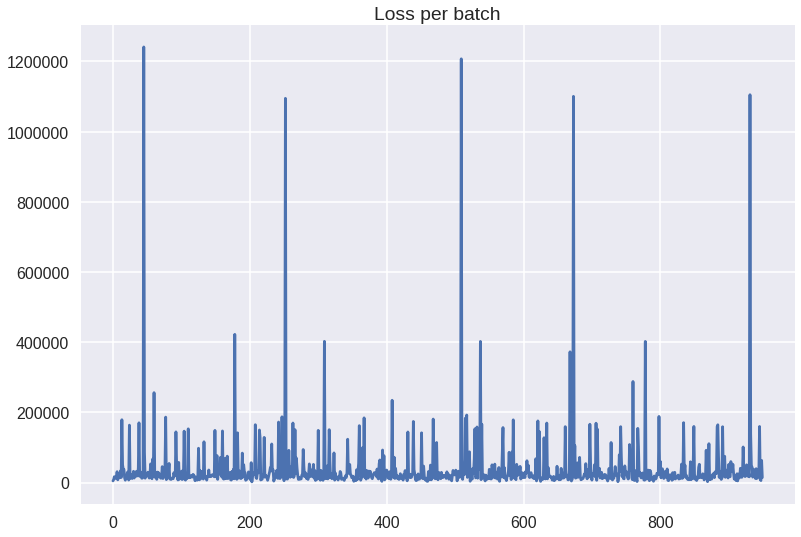

In [ ]:
training, data, model, losses = run_network(data=data, epochs=10, batch=128)
trainX, trainY, testX, testY = data
plot_losses(losses)



In [44]:
score = model.evaluate(trainX, trainY, verbose=0)

print("Network's training score [MSE]: {0}, in seconds : {1}".format(score, np.sqrt(score)))

Network's training score [MSE]: 36620.36688489848, in seconds : 191.36448700032741


In [78]:
print('\n Saving model to disk..')
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


 Saving model to disk..
Saved model to disk


# Reloading Saved MOdel

In [45]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.compile(loss="mse", optimizer="rmsprop")
print('Model model compiled!!')

Loaded model from disk
Model model compiled!!


In [46]:
score = loaded_model.evaluate(trainX, trainY, verbose=0)

print("Network's training score [MSE]: {0}, in seconds : {1}".format(score, np.sqrt(score)))

Network's training score [MSE]: 36620.36688489848, in seconds : 191.36448700032741


# Plotting Performance

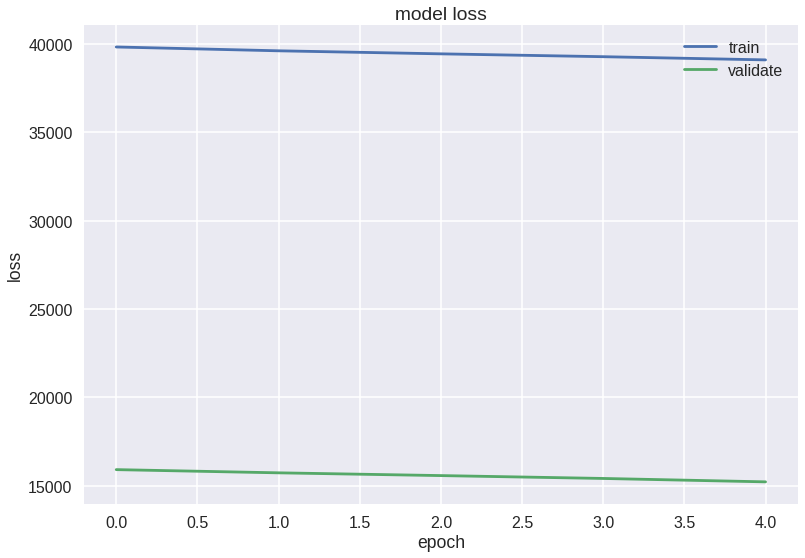

In [47]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

Results: MSE - 9211.243787  ;  seconds = 95.975


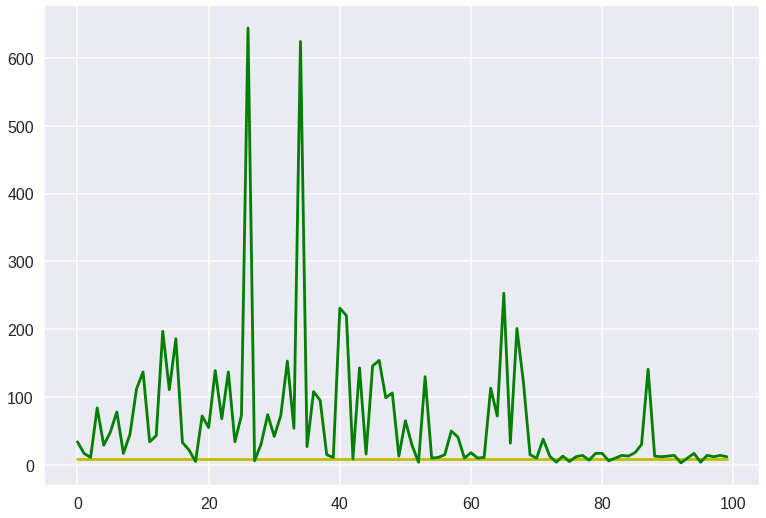

In [48]:
trainX, trainY, testX, testY = data
score = model.evaluate(testX, testY, verbose=2)

print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

predictions=model.predict(testX)
plt.plot(predictions[0:100],'y' )
plt.plot(testY[0:100], 'g')

plt.show()

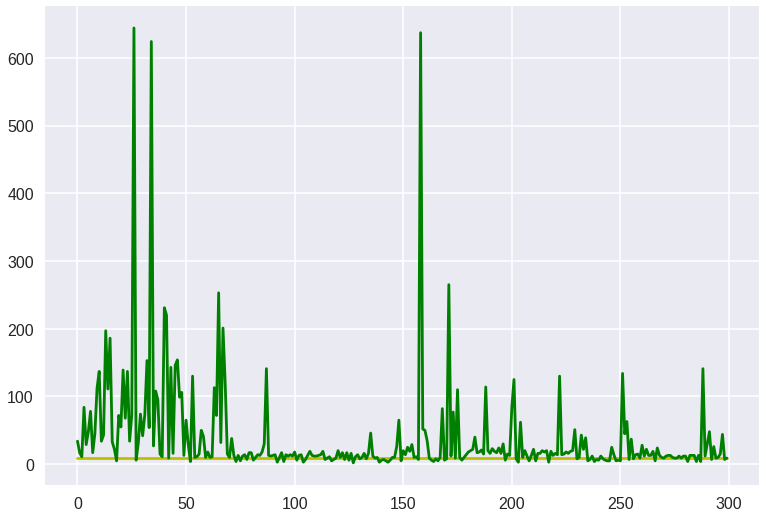

In [56]:
plt.plot(predictions[:300],'y' )
plt.plot(testY[:300], 'g')

plt.show()

In [54]:
mae = testY-predictions
print('max error : {} ; min error : {} ; Mean Error: {}'.format(np.max(mae), np.min(mae), np.mean(mae)))

max error : 1016.2979583740234 ; min error : -8.702041625976562 ; Mean Error: 30.108642848146978


In [ ]:
anomaly